# CS 4496/7496 Character Animation (Fall 2023)
Copyright (c) Georgia Institute of Technology


---


## Project 3: Tinkertoy (due <font color='red'>11/3/2023</font>, 11:59PM)

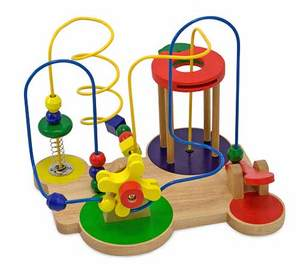

Your task is to simulate two beads under gravity. One bead must stay on a circular wire and the second bead is connected to the first one by a fixed-length rod. You will implement one constraint that keeps a bead on the circle and another that keeps two beads a fixed distance apart. Your program should simulate the motion of the beads under gravity and should draw the beads as they move.

In short, we want to simulate the motion of two beads under gravity for the following constraints:
1.   First bead must stay on a circular wire of a given radius
2.   Second bead is connected to the first one by a fixed-length rod.

*Reference: 04_ConstrDyn.pdf *

In [315]:
#@title import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# 1. Constrained system
The initial state of the system consists of the positions and velocities of the two beads.

1.   The first bead is at positon (0.6, 0.8) initially, and attached to a circle of radius 1, centered at origin
2.   The second bead is at (0.6, 0.3) initially, connected to the first bead by a rod of length 0.5.
3. Both the beads have zero initial velocity.

We need to find the legal accelerations of the two beads to keep their respective velocities and positions valid throughout the motion.

In [316]:
# number of beads in the system
n_particles = 2

# number of constraints in the system
n_constraints = 2

positions, velocities = None, None # placeholders
constraint_values = list()

def initialize():
  global positions, velocities, constraint_values
  # positions: column vector of size 2 * n_particles, concatenation of all positions of the beads
  positions = np.array([0.6, 0.8, 0.6, 0.3]).reshape(-1, 1)
  # velocities: column vector of size 2 * n_particles, concatenation of all velocities of the beads
  velocities = np.array([0., 0., 0., 0.]).reshape(-1, 1)
  # constraint_values: a list of constraint values over time
  constraint_values = list()

Given the positions and velocities of the particles, evaluate the value of constraints, C(x). C[0] is the first constraint that keeps the first particple at a circular wire (radius 1.0, center at origin). C[1] is the second constraint that maintains the distance between two particles to be 0.5. Please fill two numbers.

Compute C(*X*) for the two constraints to verify the legal positions of the two beads. ("Legal positions" are the positions at which C(*X*)=0)

eval_C(system):
  * Evaluates the corresponding constraints for the given system
  * Returns an array of shape [n_constraints, 1]

**Hint: You can access the elements of the N by 1 vector v as  ```v[0] or v[1]```.**

**<font color='orange'> \*\*Task 1: Write your code below (20 pts)\*\* </font>**


In [317]:
def eval_C(pos, vels):
  """Evaluates the value of constraints, C(x).
  Args:
    pos: a 2N by 1 position vector, [[x1], [y1], [x2], [y2], ...], where N = the number of particles (2 by default)
    vels: a 2N by 1 velocity vector, [[vx1], [vy1], [vx2], [vy2], ...], where N = the number of particles (2 by default)
  Returns:
    The C vector as a np.array of shape (2, 1)

  """
  C = np.zeros([n_constraints, 1])
  # Student code starts here
  # First particle is constrained to be on a circle with radius `r`, centered at the origin.
  r = 1.0
  C[0] = (pos[0]**2 + pos[1]**2) / 2 - r**2 / 2
  # Second particle is constrained to be at distance 0.5 away from the first particle.
  d = 0.5
  C[1] = ((pos[0] - pos[2])**2 + (pos[1] - pos[3])**2) / 2 - d**2 / 2
  # Student code ends here
  return C

Cdot is its time derivative (hint: Use the chain rule, e.g., dC/dt = dC/dX dX/dt, where X is a position variable and \dot{X} is velocity) to compute the time derivative of the first and second constraints.

eval_Cdot(system):
  * Evaluates time derivative of the constraints for the given system
  * Returns an array of shape [n_constraints, 1].

**<font color='orange'> \*\*Task 2: Write your code below (20 pts)\*\* </font>**


In [318]:
def eval_Cdot(pos, vels):
  """Evaluates the time derivative of constraints, Cdot(x).
  Args:
    pos: a 2N by 1 position vector, [[x1], [y1], [x2], [y2], ...], where N = the number of particles (2 by default)
    vels: a 2N by 1 velocity vector, [[vx1], [vy1], [vx2], [vy2], ...], where N = the number of particles (2 by default)
  Returns:
    The Cdot vector as a np.array of shape (2, 1)
  """
  Cdot = np.zeros([n_constraints, 1])
  # Student code starts here
  Cdot[0] = pos[0] * vels[0] + pos[1] * vels[1]
  Cdot[1] = (pos[0] - pos[2]) * (vels[0] - vels[2]) + (pos[1] - pos[3]) * (vels[1] - vels[3])
  # Student code ends here
  return Cdot


Lets verify the results with a simple unit test.

The test is design to verify whether
  * C and Cdots are zero when it is at the valid state.
  * C and Cdots are non zero when we perturb the state.
  
Note that our testing scenario is simple and not complete.

In [319]:
#@title Test case 1 (Do not modify)
# Simple unit tests
p0, v0 = np.array([0.6, 0.8, 0.6, 0.3]).reshape(-1, 1), np.array([0.0, 0.0, 0.0, 0.0]).reshape(-1, 1)
assert(np.allclose(eval_C(p0, v0), np.array([[0.0], [0.0]])))
assert(not np.allclose(eval_C(p0 + 0.1, v0), np.array([[0.0], [0.0]])))
assert(np.allclose(eval_Cdot(p0, v0), np.array([[0.0], [0.0]])))
assert(not np.allclose(eval_Cdot(p0, v0 + 0.1), np.array([[0.0], [0.0]])))

For simplicity, the mass of the beads are all set to 1. Therefore, the mass matrix and inverse mass matrix are simply identity matrices of size 2 * n_particles.

In [320]:
M = np.eye(n_particles * 2)
# np.eye returns the identity matrix.
# We can set the mass values, like M[0, 0] = 1.0, M[1, 1] = 1.0, ... M[3, 3] = 1.0
# but not necessary because all the masses are assumed to be zero.
W = np.eye(n_particles * 2)

We can define external forces as [fx1, fy1, fx2, fy2]. In our scenario, the only external force is gravity. Therefore, we can define the force as follows.

In [321]:
g = -10 # approximated value, instead of -9.8
Q = M @ np.tile([0, g], n_particles).reshape(-1, 1)
print("The external force vector = \n", Q)

The external force vector = 
 [[  0.]
 [-10.]
 [  0.]
 [-10.]]


In order to find lamda, we need to compute **Jacobian** i.e the partial derivative matrix of constraints with each particle and **Jacobian_dot** i.e the time derivative of Jacobian.

**[Note]**: Multiplying the constraint function by any non-zero constant also gives a valid constraint.
To remove the ambiguity, the given time derivative of Jacobian follows constraints of the form discussed in class: $C(x) =\frac{1}{2} x^2 - \frac{1}{2} r^2$

**<font color='orange'> \*\*Task 3 and 4: Write your code below (10 + 10 pts)\*\* </font>**

In [322]:
def eval_J(pos, vels):
  """Evaluates the value of the Jacobian matrix, J.
  Args:
    pos: a 2N by 1 position vector, [[x1], [y1], [x2], [y2], ...], where N = the number of particles (2 by default)
    vels: a 2N by 1 velocity vector, [[vx1], [vy1], [vx2], [vy2], ...], where N = the number of particles (2 by default)
  Returns:
    The Jacobian matrix, as a np.array of shape (M, 2N), where M = the number of constraints and  N = the number of particles (2 by 4 by default)
  """
  J = np.zeros([n_constraints, n_particles * 2]) # fill in the correct dimension of J
  # Student code starts here
  J[0, 0] = pos[0]
  J[0, 1] = pos[1]
  J[0, 2] = 0
  J[0, 3] = 0
  J[1, 0] = pos[0] - pos[2]
  J[1, 1] = pos[1] - pos[3]
  J[1, 2] = -pos[0] + pos[2]
  J[1, 3] = -pos[1] + pos[3]
  # Student code ends here
  return J

In [323]:
def eval_Jdot(poss, vels):
  """Evaluates the time derivative of the Jacobian matrix, Jdot.
  Args:
    pos: a 2N by 1 position vector, [[x1], [y1], [x2], [y2], ...], where N = the number of particles (2 by default)
    vels: a 2N by 1 velocity vector, [[vx1], [vy1], [vx2], [vy2], ...], where N = the number of particles (2 by default)
  Returns:
    The derivative of the Jacobian matrix, as a np.array of shape (M, 2N), where M = the number of constraints and  N = the number of particles (2 by 4 by default)
  """
  Jdot = np.zeros([n_constraints, n_particles * 2]) # fill in the correct dimension of Jdot
  # Student code starts here
  Jdot[0, 0] = vels[0]
  Jdot[0, 1] = vels[1]
  Jdot[0, 2] = 0
  Jdot[0, 3] = 0
  Jdot[1, 0] = vels[0] - vels[2]
  Jdot[1, 1] = vels[1] - vels[3]
  Jdot[1, 2] = -vels[0] + vels[2]
  Jdot[1, 3] = -vels[1] + vels[3]
  # Student code ends here
  return Jdot

Let's see if your codes can pass the unit test. By definition, J is a partial derivative of C with respect to x and Jdot is a partial derivative of Cdot with respect to x. The below test computes J and Jdot using numerical approximation (https://en.wikipedia.org/wiki/Finite_difference) and compares with your implementation. Please use this part as a sanity check.

In [324]:
#@title Test case 2 (Do not modify)
# Unit tests for J and Jdot
# By the definition, J is a partial derivative of C.
# And Jdot is a partial derivative of Cdot.
# Can we check them with a numerical approximation method?
p0, v0 = np.array([0.6, 0.8, 0.6, 0.3]).reshape(-1, 1), np.array([0.0, 0.0, 0.0, 0.0]).reshape(-1, 1)
# p0, v0 = np.array([0.6, 0.8, 0.6, 0.3]), np.array([0.8, -0.6, 0.0, 0.0])

h = 0.001
J = eval_J(p0, v0)
Jdot = eval_Jdot(p0, v0)
assert(J.shape == (n_constraints, n_particles * 2))
assert(Jdot.shape == (n_constraints, n_particles * 2))

for i in range(n_particles * 2):
  delta = np.zeros([n_particles * 2, 1])
  delta[i, 0] = h

  # Perturb the i th element of p0 by h
  Cm = eval_C(p0 - delta, v0)
  Cp = eval_C(p0 + delta, v0)
  dC_dpi = (Cp - Cm) / (2 * h) # Numerical approximation with finite difference
  assert(np.allclose(dC_dpi, J[:, i].reshape(-1, 1)))

  # Perturb the i th element of p0 by h
  Cdotm = eval_Cdot(p0 - delta, v0)
  Cdotp = eval_Cdot(p0 + delta, v0)
  dCdot_dpi = (Cdotp - Cdotm) / (2 * h) # Numerical approximation with finite difference
  assert(np.allclose(dCdot_dpi, Jdot[:, i].reshape(-1, 1)))

Now, we need to find the derivatives of positions and velocities of all particles at the current frame by solving the constrained dynamics. It takes the following three steps:

1. Evaluate the Lagrangian multipliers (lambda) with feedback terms.
2. Evaluate constraint force *Q_hat*.
3. Derivatives of positions and velocities of the beads.

**<font color='orange'> \*\*Task 5, 6, 7: Write your code below (10 + 10 + 10 pts)\*\* </font>**


In [325]:
def eval_derivative(pos, vels):
  """Evaluates derivaties of the given system by computing the collision forces.
  Args:
    pos: a 2N by 1 position vector, [[x1], [y1], [x2], [y2], ...], where N = the number of particles (2 by default)
    vels: a 2N by 1 velocity vector, [[vx1], [vy1], [vx2], [vy2], ...], where N = the number of particles (2 by default)
  Returns:
    positions_derivative: a 2N by 1 vector that represents the derivative of the positions, [[xdot1], [ydot1], [xdot2], [ydot2], ...], where N = the number of particles (2 by default)
    velocities_derivative: a 2N by 1 vector that represents the derivative of the velocities, [[xdotdot1], [ydotdot1], [xdotdot2], [ydotdot2], ...], where N = the number of particles (2 by default)
  """
  global M, W, Q
  C = eval_C(pos, vels)
  Cdot = eval_Cdot(pos, vels)
  J = eval_J(pos, vels)
  Jdot = eval_Jdot(pos, vels)

  positions_derivative = np.zeros(pos.shape)
  velocities_derivative = np.zeros(vels.shape)

  # Feedback terms parameters
  # You can tune these values
  ks = 1.0
  kd = 1.0

  # Student code starts here

  # 1) Compute the Lagrangian multipliers w/ feedback terms
  # J shape: (2, 4)
  # Jdot shape: (2, 4)
  # vels shape: (4, 1)
  # C shape: (2, 1)
  # Cdot shape: (2, 1)
  # M shape: (4, 4)
  # Q shape: (4, 1)
  # M is the identity matrix.
  A = J @ W @ J.T
  b = -(J @ W @ vels + J @ Q + Jdot @ vels + kd * Cdot + ks * C)
  lam = np.linalg.solve(A, b)

  # 2) Compute the constraint forces
  f_con = J.T @ lam

  # 3) Compute positions_derivative and velocities_derivative
  positions_derivative = vels
  velocities_derivative = W @ (Q + f_con)
  # velocities_derivative shape: (4, 1)

  # Student code ends here
  assert(positions_derivative.shape == positions.shape)
  assert(velocities_derivative.shape == velocities.shape)
  return positions_derivative, velocities_derivative


Now we need the integrators.
Two integrators, Explicit Euler and Midpoint methods are given.

In [326]:
def explicit_euler(dt):
  """Advances the positions and velocities by dt using the Euler method."""
  global positions, velocities
  # modifies positions, velocities
  dp, dv = eval_derivative(positions, velocities)
  positions += dt * dp
  velocities += dt * dv

def mid_point(dt):
  """Advances the positions and velocities by dt using the Midpoint method."""
  global positions, velocities
  # modifies positions, velocities
  dp, dv = eval_derivative(positions, velocities)
  mp = positions + dt * dp * 0.5
  mv = velocities + dt * dv * 0.5
  dp, dv = eval_derivative(mp, mv)
  positions += dt * dp
  velocities += dt * dv

def update(dt):
  global positions, velocities, constraint_values
  # **** change this line if you want to switch the integrator ****
  # explicit_euler(dt)
  mid_point(dt)

  # record the constraint values
  C = eval_C(positions, velocities)
  constraint_values.append(C.reshape(-1))


Function calls for creating animations. Do not modify this part (unless you are working on extra questions).

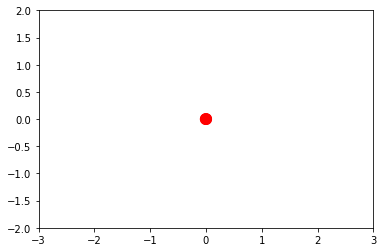

In [327]:
#@title Animation (do not modify)
n = n_particles
# Figure and shape placeholders
fig, ax = plt.subplots()
ax.set_xlim((-3.0, 3.0))
ax.set_ylim((-2.0, 2.0))
circle, = ax.plot([], [], 'b')
rod, = ax.plot([], [], 'k')
beads = []
for i in range(n):
  bead = plt.Circle((0, 0), 0.10, color='r')
  beads.append(bead)
  ax.add_artist(bead)

# plot circle, rod and beads
def plot_scene():
  circle.set_data(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)))
  rod.set_data([positions[0], positions[2]], [positions[1], positions[3]])
  for i in range(n):
    beads[i].set_center(positions[2*i:2*i+2])

# Called before the first frame
def init_animation():
  plot_scene()
  return []

# Called every frame
def animate(i):
  if i % 25 == 0:
    print("Generating frame #%d..." % i)
  update(0.01)
  plot_scene()
  return []




Generate your animation!

In [328]:
#@title Animation2 (do not modify)
initialize()
anim = animation.FuncAnimation(fig, animate, init_func=init_animation, frames=500, interval=20, blit=False)
HTML(anim.to_html5_video())

Generating frame #0...
Generating frame #25...
Generating frame #50...
Generating frame #75...
Generating frame #100...
Generating frame #125...
Generating frame #150...
Generating frame #175...
Generating frame #200...
Generating frame #225...
Generating frame #250...
Generating frame #275...
Generating frame #300...
Generating frame #325...
Generating frame #350...
Generating frame #375...
Generating frame #400...
Generating frame #425...
Generating frame #450...
Generating frame #475...


Let's plot both constraint values. Are they near zero during the entire simulation?

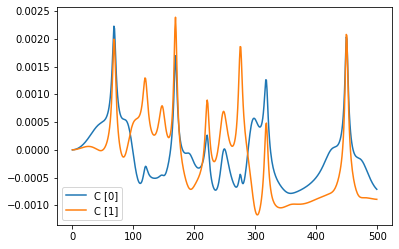

In [329]:
#@title Plotting (do not modify)
constraint_values = np.array(constraint_values)
plt.plot(constraint_values[:, 0], label="C [0]")
plt.plot(constraint_values[:, 1], label="C [1]")
plt.legend()

What is the purpose of feedback terms (ks/kd)? Repeat the experiments without the feedback terms by setting ks=kd=0, and discuss the results.

**<font color='orange'> \*\*Task 8: Write your code below (10 pts)\*\* </font>**


The purpose of the feedback terms, $k_s$/$k_d$, are to stabilize the system.

$k_s$ is the stiffness coefficient, which pulls the system back to the constraint region when it drifts away.
$k_d$ is the damping coefficient, which damps out oscillations as it approaches the constraint region.

I actually don't notice much visually change at all in the animation when I change them both from one to zero. However, I do observe that the constraint values drift about twice as far away from zero in the plot - ranging down to around -0.002 instead of -0.001.

I suppose this could be because the system is simple, relatively stable, and uses small enough timesteps, and is thus stable enough without the additional constraints to remain close enough to the constraints as to be visually acceptable.

# 2. Extra points

## 2.1. Dynamic Forces
Apply extra forces a few times during the simulation. Don't forget to visualize the forces as lines. You are expected to directly modify the above code (hint: update the global force vector Q with respect to time. You can modify either update or animate functions).

**<font color='orange'> \*\*edit the above code directly and explain your implmenetation below (2 pts)\*\* </font>**

(explain your implementation here)

## 2.2. Advanced Solver
Implement the RK4 solver and verify that it is better than other methods.

**<font color='orange'> \*\*edit the above code directly and explain your implmenetation below (2 pts)\*\* </font>**

(explain your implementation here)

## 2.3. Novel Constraints
Implement additional types of constraints for the tinkertoy (e.g. an additional bead is connected to the second bead or three beads should always form an equilateral triangle). If the constraint outputs more than a single scalar, you need to modify the indexing scheme for the global matrices and vectors so that the constraint evaluations and derivatives are stored in the correct places.

Here's one inspiring example: https://youtu.be/ShtiCeJWIxw

Here's another example: https://youtu.be/owtcj_SIYO8 This example simulates staircase motions of a particle by toggling between the vertical (x=Cx) and horizontal (y = Cy) line constraints. Toggling of the constraints may give you a chance to generate more expressive animations.


**<font color='orange'> \*\*edit the above code directly and explain your implmenetation below (6 pts)\*\* </font>**

(explain your implementation here)